# Toxic Comment Classification

You may be familiar with the saying, "sticks and stones may break my bones (but words can never hurt me)." As much as we'd like to believe words can't affect us, it's not true.

For many, the internet is the primary mode of connecting with others and an outlet for people to express themselves. Platforms such as YouTube enables creative individuals to turn their ability to entertain others into a career. Unfortunately, this makes them a prime target for people who enjoy verbally abusing others. Being bombarded with toxic comments can be detrimental to one's health. Now influences are opening up about the emotional damage these comments inflict on them and their battles with depression and anxiety.

This project aims to find a machine-learning model capable of discovering toxic comments that will assist content creators in improving their communities.

# Importing Tools

In [2]:
import pandas as pd
import re
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer
import warnings
import pickle
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
f1_score, roc_auc_score, roc_curve, precision_recall_curve,classification_report,label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from numba import jit, cuda
import imblearn
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Data

A dataset from Kaggle.com containing comments from Wikipedia will be used to create the prototype. The attributes of this set are:
* Comment ID (Data Type – String)
* Comments (Data Type - String)
* Toxic Label (Data Type - Integer)
* Toxic Categories (Data Types – Integer)
    * Severe Toxic	
    * Obscene
    * Threat	
    * Insult
    * Identity Hate

In [3]:
df = pd.read_csv("input/updated_train_data.csv")

In [4]:
# function to clean the text performin some simple regex pattern matching
def apply_regex(corpus):
    # removes numbers and words concatenated with numbers
    corpus = corpus.apply(lambda x: re.sub("\S*\d\S*"," ", x)) 
    # removes emails and mentions (words with @)
    corpus = corpus.apply(lambda x: re.sub("\S*@\S*\s?"," ", x))  
    # removes hashtags (words with #)
    corpus = corpus.apply(lambda x: re.sub("\S*#\S*\s?"," ", x)) 
    # removes URLs
    corpus = corpus.apply(lambda x: re.sub(r'http\S+', ' ', x))
    # keeps numbers and letters
    corpus = corpus.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ',x))  
    # replaces the ASCII '�' symbol with '8'
    corpus = corpus.apply(lambda x: x.replace(u'\ufffd', '8'))  
    # removes multiple spaces
    corpus = corpus.apply(lambda x: re.sub(' +', ' ', x))  
    # removes newline chars
    corpus = corpus.apply(lambda x: x.replace('\n',' '))               
    corpus = corpus.apply(lambda x: x.replace('\r',' '))
    return corpus

In [5]:
# apply the function and clean the data
feature = "comment_text"
df[feature] = apply_regex(df[feature])
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neg,neu,pos,compound,sentiment
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,0.000,0.897,0.103,0.5574,positive
1,000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0,0.099,0.743,0.158,0.2942,positive
2,000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0,0.083,0.849,0.068,-0.1779,negative
3,0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0,0.022,0.916,0.062,0.5106,positive
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,0.000,0.663,0.337,0.6808,positive


# Sentiment Analysis

The purpose of this section is to demonstrate the data modification process of the original set. It doesn't need to be executed.

In [8]:
#Importing orignal comment data
# comm = pd.read_csv('./input/traindata/traindata.csv',encoding='utf8',error_bad_lines=False,index_col=False)

In [9]:
sid = SentimentIntensityAnalyzer()

In [10]:
def get_pol(df):
    df['neg'] = df['comment_text'].apply(lambda comment_text:sid.polarity_scores(str(comment_text))['neg'])
    df['neu'] = df['comment_text'].apply(lambda comment_text:sid.polarity_scores(str(comment_text))['neu'])
    df['pos'] = df['comment_text'].apply(lambda comment_text:sid.polarity_scores(str(comment_text))['pos'])
    df['compound'] = df['comment_text'].apply(lambda comment_text:sid.polarity_scores(str(comment_text))['compound'])
    return df

In [11]:
from numba import jit, cuda
import numpy as np
    
# function optimized to run on gpu 
@jit(target_backend='cuda')    
def sentiment_score(df):
	for i,score in enumerate(df['compound']):
		if float(score) > 0:
			df['sentiment'][i] = 'positive'
		elif float(score) == 0.0:
			df['sentiment'][i] = 'neutral'
		else:
			df['sentiment'][i] ='negative'
	return df

In [12]:
# df = get_pol(comm)
# df = sentiment_score(df)

In [42]:
# filename = './input/traindata/updated_train_data.csv'  
# df.to_csv(file_name, encoding='utf-8', index=False)

# Deriving Features

## Toxicity Rating Scale
The original data set assigned categories to toxic comments. To rate the toxicity of a statement, I've added the labels. For example, a comment considered severely toxic, obscene, threatening, insulting, and containing hate speech scores five on the rating scale.

**Note**: If a comment falls into any toxic category, the column labeled 'toxic' will also be marked as true (1). So I ignored that column when finding the total score.

In [6]:
col_list = ['severe_toxic','obscene','threat','insult','identity_hate']
df['score'] = df[col_list].astype(int).sum(axis=1)
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neg,neu,pos,compound,sentiment,score
48704,8237e75511a995fb,Thanks I recommended that we have fifteen que...,0,0,0,0,0,0,0.000,0.858,0.142,0.7777,positive,0
47353,7e8196fbc39bbcb6,The Theme of the season y Glamour,0,0,0,0,0,0,0.000,1.000,0.000,0.0000,neutral,0
10618,1c088e7d5a015569,Is Wikipedia a patriarchal site Is Wikipedia a...,0,0,0,0,0,0,0.109,0.858,0.032,-0.9727,negative,0
96949,06acd75519db5fba,Dear Snigbrook Your days are numbered the stab...,1,0,1,1,1,0,0.253,0.526,0.220,-0.5033,negative,3
28548,4b99213bc19b2f66,IAPT I actually thought when i got up this mor...,0,0,0,0,0,0,0.000,0.918,0.082,0.3976,positive,0


# EDA

In [7]:
def toxic_score_dist(df):
        order= range(6)
        ax1 = sns.countplot(x = df["score"],order=order)
        plt.title('Distribution of Toxic Comments')
        plt.xlabel('Toxicity Rating')
        plt.ylabel('Count')
        for container in ax1.containers:
            plt.bar_label(container)
        plt.show()

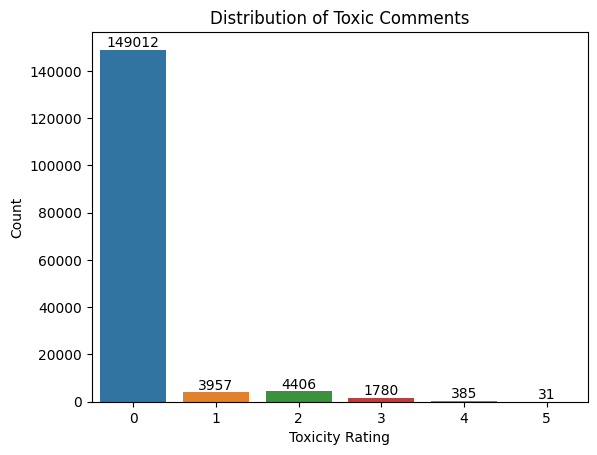

In [8]:
toxic_score_dist(df)

In [9]:
def sentiment_dist(df):
        order = ['negative','neutral','positive']
        sns.countplot(x = df["sentiment"],order = order)
        plt.title('Distribution Sentiment')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.show()

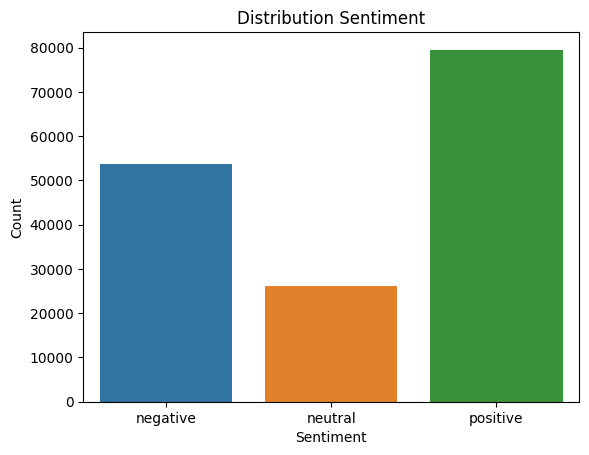

In [10]:
sentiment_dist(df)

# Modeling

## Combining Text Columns

I combined the columns before encoding to evaluate both the sentiment and comment text.

**Note**: I know now combining columns was not the correct way to do this. See lessons learned at the bottom. 

In [11]:
X = pd.DataFrame(df['sentiment'] +' '+ df['comment_text'])
X = pd.DataFrame(df['comment_text'])
X.columns = ['text']

## Splitting and Encoding

In [12]:
y = df[['score']]
X_train,X_test,y_train,y_test = train_test_split(X['text'],y,random_state = 42)

In [13]:
# encodin text into vectors
tfid = TfidfVectorizer(lowercase=False,max_features=500)

train_vectors_tfidf = tfid.fit_transform(X_train).toarray()
test_vectors_tfidf = tfid.transform(X_test).toarray()

## Normalizing

In [14]:
oversample = RandomOverSampler(sampling_strategy='minority')
train_vectors_tfidf, y_train_tfidf = oversample.fit_resample(train_vectors_tfidf, y_train.values.ravel())
test_vectors_tfidf, y_test_tfidf = oversample.fit_resample(test_vectors_tfidf, y_test)

In [15]:
norm_TFIDF = Normalizer(copy=False)
norm_train_tfidf = norm_TFIDF.fit_transform(train_vectors_tfidf)
norm_test_tfidf = norm_TFIDF.transform(test_vectors_tfidf)

## Logistic Regression Model

In [16]:
model = LogisticRegression(random_state=42, multi_class='multinomial',class_weight='balanced', n_jobs=6, max_iter=300)
model.fit(norm_train_tfidf, y_train_tfidf);


## Evaluating the Model

In [17]:
prediction = model.predict(norm_test_tfidf)

In [18]:
print(prediction)

[1 0 0 ... 5 4 5]


In [19]:
pprob = model.predict_proba(norm_test_tfidf) 

In [20]:
cr = classification_report(y_test_tfidf, prediction,output_dict=True)
pd.DataFrame(cr)

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.986876,0.06250,0.110922,0.083014,0.001346,0.970323,0.538641,0.369163,0.947265
recall,0.762227,0.34104,0.234445,0.284464,0.368421,0.333199,0.538641,0.387300,0.538641
f1-score,0.860125,0.10564,0.150594,0.128522,0.002681,0.496057,0.538641,0.290603,0.658702
support,37191.000000,1038.00000,1109.000000,457.000000,95.000000,37191.000000,0.538641,77081.000000,77081.000000


In [21]:
print(confusion_matrix(y_test_tfidf,prediction))

[[28348  4940  1823  1023   810   247]
 [  238   354   174   136   104    32]
 [  124   270   260   247   158    50]
 [   12    84    82   130   105    44]
 [    3    16     5    30    35     6]
 [    0     0     0     0 24799 12392]]


In [35]:
def plot_confusion_matrix(y_test,y_preds):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_preds),cmap="rocket")
    plt.xlabel("True Toxic Score")
    plt.ylabel("Predicted Toxic Score")

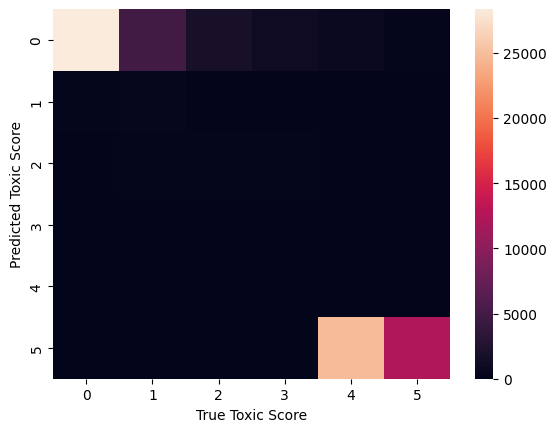

In [36]:
plot_confusion_matrix(y_test_tfidf,prediction)

The model seems to be the most accurate when predicting nontoxic comments. The results are not surprising, considering the dataset mainly consists of nontoxic remarks and hardly contains statements on the other end of the spectrum. 

In [24]:
# filename = 'logist_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# Final Thoughts and Lessons Learned

The initial design was to determine if a user's comment is toxic by comparing a statement's sentiment to its replies and the number of dislikes it receives. I also wanted to explore the gray area of distinguishing between toxic comments and unpopular opinions. 

After my project was approved, YouTube removed the ability to access dislikes through their API.So, the analysis was performed only on sentiment and comment contents. The new idea was that sentiment analysis would increase the model's accuracy.  

I encountered difficulties attempting to encode sentiment and text as separate features. My solution was to combine the columns because both attributes are words. In hindsight, I realize that my adding one of three words to each comment is a terrible idea when using TF-IDF. Because TF-IDF considers words that frequently appear in the document to be more important, the sentiment became the focus instead of supplemental to the actual comment. Using TF-IDF explains why the model returns many false positives. The bulk of the toxic comments contains a negative sentiment. Therefore the model will be more likely to label negative sentiments as toxic.

To improve my work, I plan to test different models and encodings and perform more robust sentiment analysis. I'm also looking into alternative methods for collecting data.